## 전체 딥러닝 플로우 구현 해보기

In [52]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt 
%matplotlib inline

#### 데이터 Load 와 전처리

In [53]:
import torch
from torchvision import datasets, transforms

In [54]:
batch_size = 32

In [55]:
# (img - mean) / std
# 정규화

In [56]:

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('dataset/', download=True, train=True, \
        transform=transforms.Compose(
            [
            transforms.ToTensor(),
            transforms.Normalize(mean = (0.5,), std = (0.5,))
                                # 해당 분포를 따르는 스케일로 변경하겠다.
            ]
        )),
    batch_size=batch_size,
    shuffle=True
)

In [57]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('dataset/', train=False, \
        transform=transforms.Compose(
            [
            transforms.ToTensor(),
            transforms.Normalize(mean = (0.5,), std = (0.5,))
                                # 해당 분포를 따르는 스케일로 변경하겠다.
            ]
        )),
    batch_size=batch_size,
    shuffle=False
)

#### 데이터 확인

PyTorch에서는 TF와 이미지를 표현하는데 있어서 차이점이 있음. 

- TF - (batch, height, width, channel)
- PyTorch - (batch, channel, height, width)

In [58]:
images, labels = next(iter(train_loader))

In [59]:
images.shape, images.dtype

(torch.Size([32, 1, 28, 28]), torch.float32)

In [60]:
images[0].shape

torch.Size([1, 28, 28])

In [61]:
torch_image = torch.squeeze(images[1])

In [62]:
torch_image.shape

torch.Size([28, 28])

In [63]:
torch_image.numpy()[0]

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1.], dtype=float32)

In [64]:
image = torch_image.numpy()
label = labels[1].numpy()

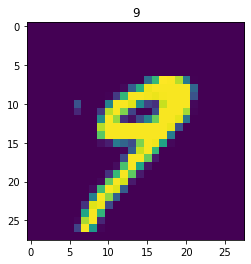

In [65]:
plt.title(label)
plt.imshow(image)
plt.show()

----

### 모델 정의 

In [66]:
from torch import nn
import torch.nn.functional as F

In [67]:
# conv = nn.Conv2d(params)
# conv(x)

# F.relu(x)
# F.max_pool2d(x, (2, 2))

In [68]:
# fn = tf.keras.layers.Conv2D()    # functional
# fn(x)

In [69]:
# 모델 만들기   
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
                                # pytorch에서는 input, output을 매번 정해줘야 한다.
                                # tf.keras.layers.Conv2D(filters=)
                                # tf.keras.layers.Dense(filters=100)

        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))   # activation
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [70]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [71]:
model = Net().to(device)

In [72]:
print(model)

Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


### 학습 로직

PyTorch에서는 model을 Training 모드로 변경 후 Training 할 수 있다. 

In [73]:
# epoch
#  - batch
#   - model
#   - loss
#   - grad
#   - model update

In [74]:
import torch.optim as optim

In [75]:
opt = optim.SGD(model.parameters(), 0.03)
                # model의 weight를 등록하고
                                    # learning rate를 등록

In [76]:
x,y = next(iter(train_loader))

In [77]:
x.shape, y.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [78]:
model.parameters()

<generator object Module.parameters at 0x164bd24a0>

#### Training mode로 ! 

In [79]:
model.train()

Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

#### Evaluation mode로 !

In [80]:
model.eval()

Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [81]:
for epoch in range(1):
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        opt.zero_grad()

        output = model(data)
                        
        loss = F.nll_loss(output, target)
                        # 예측, #정답
                        # y.shape 사이즈가 ohe 되지 않았기 때문에 사용
        loss.backward()

        opt.step()

        print('batch {} loss : {}'.format(batch_idx, loss.item()))

    model.eval()

    test_loss = 0

    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += F.nll_loss(output, target).item()
    test_loss /= (len(test_loader.dataset) // batch_size)

    print('Epoch {} test loss : {}'.format(epoch, test_loss))
        

batch 0 loss : 2.297837257385254
batch 1 loss : 2.2959389686584473
batch 2 loss : 2.286917209625244
batch 3 loss : 2.322261095046997
batch 4 loss : 2.294482707977295
batch 5 loss : 2.2799930572509766
batch 6 loss : 2.28843092918396
batch 7 loss : 2.3036673069000244
batch 8 loss : 2.291792631149292
batch 9 loss : 2.2992866039276123
batch 10 loss : 2.284848213195801
batch 11 loss : 2.289210319519043
batch 12 loss : 2.279237747192383
batch 13 loss : 2.2654521465301514
batch 14 loss : 2.261046886444092
batch 15 loss : 2.245978832244873
batch 16 loss : 2.263583183288574
batch 17 loss : 2.2681708335876465
batch 18 loss : 2.247087240219116
batch 19 loss : 2.275162935256958
batch 20 loss : 2.233429193496704
batch 21 loss : 2.236748456954956
batch 22 loss : 2.247743844985962
batch 23 loss : 2.2445061206817627
batch 24 loss : 2.229224920272827
batch 25 loss : 2.205974817276001
batch 26 loss : 2.2017130851745605
batch 27 loss : 2.1929433345794678
batch 28 loss : 2.254809617996216
batch 29 loss : 

In [82]:
# 해설용
# for epoch in range(10):
#     # Train Mode
#     model.train()
#     for batch_idx, (data, target) in enumerate(train_loader):
        
#         data, target = data.to(device), target.to(device)
        
#         optimizer.zero_grad()
        
#         output = model(data)
#         loss = F.cross_entropy(output, target)
        
#         loss.backward()
        
#         optimizer.step()
        
#         if batch_idx % 1000 == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100 * batch_idx / len(train_loader), loss.item(), end="\r"
#             ))
            
#     model.eval()

#     test_loss = 0
#     correct = 0
#     with torch.no_grad():
#         for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
#             output = model(data)
#             test_loss += F.cross_entropy(output, target, reduction='sum').item()
#             pred = output.argmax(dim=1, keepdim=True)
#             correct += pred.eq(target.view_as(pred)).sum().item()

#     test_loss /= len(test_loader.dataset)

#     print('\nTest set: Average Loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))

-----

### Evaluation

In [83]:
# Test mode
model.eval() 
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)

print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))


Test set: Average loss: 0.0579, Accuracy: 9824/10000 (98%)



- autograd engine, 즉 backpropagatin이나 gradient 계산 등을 꺼서 memory usage를 줄이고 속도를 높임